In [1]:
import torch
import matplotlib.pyplot as plt


In [2]:

def relu(y_hat):
    return torch.max(torch.zeros_like(y_hat), y_hat)


def decision_boundary(x0, w0, w1, b):
    x1 = -x0* w0/w1  - b/w1
    return x1


def plot_neural_network_response(model):
    with torch.no_grad():
        yaxis = torch.linspace(-2, 2, steps=1000)
        xaxis = torch.linspace(-2, 2, steps=1000)

        input_feats = torch.cartesian_prod(xaxis, yaxis)    # 100*100, 2
        input_feats = input_feats.unsqueeze(-1)             # 100*100, 2, 1
        
        response = model.forward(input_feats)
        
        response = response.reshape(1000, 1000)
        response = response.T # transpose as imshow origin is 'lower'.

        plt.imshow(response > 0, 
            extent=[min(xaxis),max(xaxis),min(yaxis),max(yaxis)],
            origin='lower',
            alpha=0.5)
        plt.colorbar()


def plot_boundary_and_input_features(model, input_features, labels, plot_label, style):
    for x, y in zip(input_features, labels):
        if y.item() == -1:
            plt.scatter(x[0], x[1], c='red', s = 1)
        elif y.item() == 1:
            plt.scatter(x[0], x[1], c='green', s = 1)

    xaxis = torch.arange(-2, 2, step=0.01)

    w0 = model.w[0].detach()
    w1 = model.w[1].detach()
    b = model.b.detach()

    boundary = decision_boundary(xaxis, w0, w1, b)
    plt.plot(xaxis, boundary, style, label=plot_label)
    

    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.legend()

def optimize_weights(param, learning_rate):
    param_new = param - learning_rate * param.grad
    param.data = param_new
    
def generate_circle_data(n_samples=1000, radius =1):
    import math
    # (x-a)^{2}+(y-b)^{2}=r^{2}
    assert radius < 2
    length_of_1d = math.ceil(math.sqrt(n_samples))
    xaxis = torch.linspace(-2, 2, length_of_1d)
    yaxis = torch.linspace(-2, 2, length_of_1d)


    input_feats = torch.cartesian_prod(xaxis, yaxis)[:n_samples]    # n_samples, 2
    input_feats = input_feats.unsqueeze(-1)                         # n_samples, 2, 1

    # labels = torch.ones_like(input_feats)   # 
    
    labels = (input_feats[:, 0:1]**2 + input_feats[:, 1:2]**2 > radius**2).float() * -1 \
        + (input_feats[:, 0:1]**2 + input_feats[:, 1:2]**2 < radius**2).float() * 1

    input_feats = [feat for feat in input_feats] # convert to list, each 2,1
    labels = [feat for feat in labels] # convert to list, each 1,1

    assert len(input_feats) == n_samples

    return input_feats, labels


def train(model, epochs, input_features, labels, loss_function, learning_rate):
    losses = []
    for epoch in range(epochs):

        # stack the input features and labels along the first dim
        x = torch.stack(input_features, 0)
        y = torch.stack(labels)
        # apply model
        y_hat = model.forward(x)
        
        # print(x.shape)
        loss = loss_function(y_hat, y)
        losses.append(loss.detach().item())
        # zero_grad
        model.zero_grad()
        # perform backward
        loss.backward()

        # optimize weights
        for param in model.parameters():
            optimize_weights(param, learning_rate)

    return losses

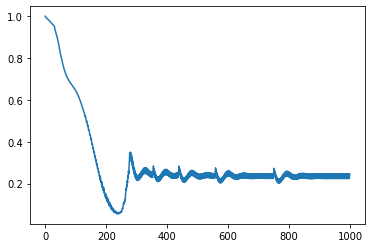

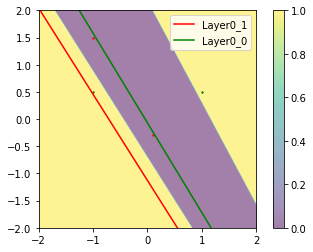

In [3]:
# Ex 1.1.

class Linear(torch.nn.Module):
    def __init__(self,num_in_features, num_out_features):
        super().__init__()
       
        w = torch.FloatTensor(num_in_features, num_out_features)
        w = torch.nn.init.uniform_(w, -0.2, 0.2)
        b = torch.FloatTensor(num_out_features)
        b = torch.nn.init.uniform_(b, -0.2, 0.2)
        self.w = torch.nn.Parameter(w, requires_grad=True)
        self.b = torch.nn.Parameter(b, requires_grad=True)
        
    def forward(self, x):        
        return self.w.T @ x  + self.b 

class TwoLayerNN(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.layer0_0 = Linear(2, 1)
        self.layer0_1 = Linear(2, 1)
        self.layer1 = Linear(2, 1)

    def forward(self, x):
        y_hat0_l0 = self.layer0_0.forward(x) 
        y_hat1_l0 = self.layer0_1.forward(x) 
        z_0 = torch.relu(y_hat0_l0) 
        z_1 = torch.relu(y_hat1_l0)
        z = torch.cat([z_0, z_1], dim=-2)
        y_hat = self.layer1.forward(z)
        return y_hat

input_features = [torch.tensor([[1.0], [0.5]], requires_grad=False), 
                torch.tensor([[-1.0], [1.5]], requires_grad=False),
                torch.tensor([[-1.0], [0.5]], requires_grad=False),
                torch.tensor([[0.1], [-0.3]], requires_grad=False)]

labels = [torch.tensor([[1.0]]),torch.tensor([[-1.0]]), torch.tensor([[1.0]]), torch.tensor([[-1.0]])]

def loss_function(y_hat, y):
    return torch.mean((y_hat - y)**2)

torch.manual_seed(8)

model = TwoLayerNN()
epochs = 1000
learning_rate = 0.1
losses = train(model, epochs, input_features, labels, loss_function, learning_rate)

plt.plot(losses)
plt.show()
plot_boundary_and_input_features(model.layer0_1, input_features, labels, "Layer0_1", 'red')
plot_boundary_and_input_features(model.layer0_0, input_features, labels, "Layer0_0", 'green')

plot_neural_network_response(model)

plt.show()

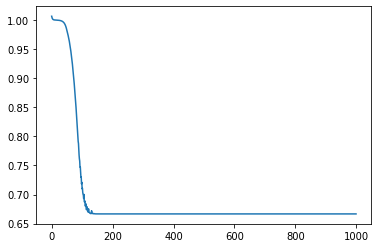

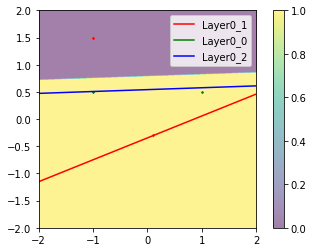

In [4]:
# Ex 1.2.

class TwoLayerNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer0_0 = Linear(2, 1)
        self.layer0_1 = Linear(2, 1)
        self.layer0_2 = Linear(2, 1)
        self.layer1 = Linear(3, 1) 

    def forward(self, x):
        y_hat0_l0 = self.layer0_0.forward(x) 
        y_hat1_l0 = self.layer0_1.forward(x) 
        y_hat2_l0 = self.layer0_2.forward(x)
        z_0 = torch.relu(y_hat0_l0) 
        z_1 = torch.relu(y_hat1_l0)
        z_2 = torch.relu(y_hat2_l0)
        z = torch.cat([z_0, z_1, z_2], dim=-2)
        y_hat = self.layer1.forward(z)
        return y_hat
    
input_features = [torch.tensor([[1.0], [0.5]], requires_grad=False), 
                torch.tensor([[-1.0], [1.5]], requires_grad=False),
                torch.tensor([[-1.0], [0.5]], requires_grad=False),
                torch.tensor([[0.1], [-0.3]], requires_grad=False)]

# the labels for XOR
labels = [torch.tensor([[1.0]]),torch.tensor([[-1.0]]), torch.tensor([[1.0]]), torch.tensor([[-1.0]])]


def loss_function(y_hat, y):
    return torch.mean((y_hat - y)**2)

# apply seed for random number generator before the model
torch.manual_seed(10)

model = TwoLayerNN()
epochs = 1000
learning_rate = 0.1
losses = train(model, epochs, input_features, labels, loss_function, learning_rate)

plt.plot(losses)
plt.show()
plot_boundary_and_input_features(model.layer0_1, input_features, labels, "Layer0_1", 'red')
plot_boundary_and_input_features(model.layer0_0, input_features, labels, "Layer0_0", 'green')
plot_boundary_and_input_features(model.layer0_2, input_features, labels, "Layer0_2", 'blue')

plot_neural_network_response(model)

plt.show()


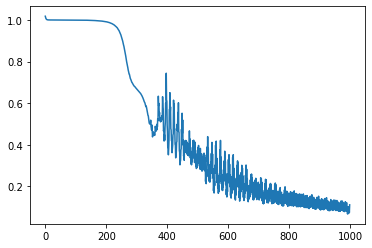

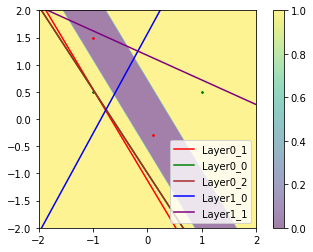

In [11]:

# Ex 1.3.

class ThreeLayerNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer0_0 = Linear(2, 1)
        self.layer0_1 = Linear(2, 1)
        self.layer0_2 = Linear(2, 1)
        self.layer1_0 = Linear(3, 1)
        self.layer1_1 = Linear(3, 1)
        self.layer2=Linear(2,1) #output

    def forward(self, x):
        y_hat0_l0 = self.layer0_0.forward(x) 
        y_hat1_l0 = self.layer0_1.forward(x) 
        y_hat2_l0 = self.layer0_2.forward(x)
        z_0 = torch.relu(y_hat0_l0) 
        z_1 = torch.relu(y_hat1_l0)
        z_2 = torch.relu(y_hat2_l0)
        z = torch.cat([z_0, z_1, z_2], dim=-2)
        y_hat0_l1 = self.layer1_0.forward(z)
        y_hat1_l1 = self.layer1_1.forward(z)
        z_0_l1 = torch.relu(y_hat0_l1) 
        z_1_l1 = torch.relu(y_hat1_l1)
        z_l1 = torch.cat([z_0_l1, z_1_l1], dim=-2)
        y_hat = self.layer2.forward(z_l1)
        return y_hat


input_features = [torch.tensor([[1.0], [0.5]], requires_grad=False), 
                torch.tensor([[-1.0], [1.5]], requires_grad=False),
                torch.tensor([[-1.0], [0.5]], requires_grad=False),
                torch.tensor([[0.1], [-0.3]], requires_grad=False)]

# the labels for XOR
labels = [torch.tensor([[1.0]]),torch.tensor([[-1.0]]), torch.tensor([[1.0]]), torch.tensor([[-1.0]])]


def loss_function(y_hat, y):
    return torch.mean((y_hat - y)**2)

# apply seed for random number generator before the model
torch.manual_seed(8)

model = ThreeLayerNN()
epochs = 1000
learning_rate = 0.1
losses = train(model, epochs, input_features, labels, loss_function, learning_rate)

plt.plot(losses)
plt.show()
plot_boundary_and_input_features(model.layer0_1, input_features, labels, "Layer0_1", 'red')
plot_boundary_and_input_features(model.layer0_0, input_features, labels, "Layer0_0", 'green')
plot_boundary_and_input_features(model.layer0_0, input_features, labels, "Layer0_2", 'brown')
plot_boundary_and_input_features(model.layer1_0, input_features, labels, "Layer1_0", 'blue') 
plot_boundary_and_input_features(model.layer1_1, input_features, labels, "Layer1_1", 'purple') 

plot_neural_network_response(model)

plt.show()


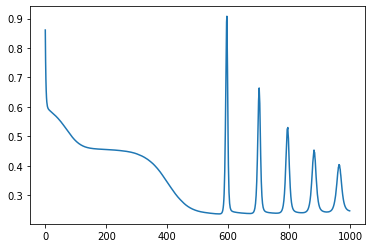

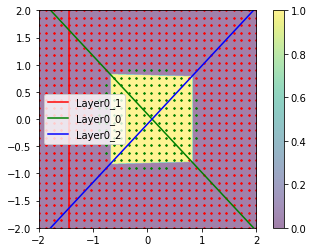

In [ ]:
# Ex. 1.4: Lets fit a circle :)

input_features, labels = generate_circle_data(n_samples=900)

torch.manual_seed(12)
model = TwoLayerNN()
epochs = 1000
learning_rate = 0.1
losses = train(model, epochs, input_features, labels, loss_function, learning_rate)

plt.plot(losses)
plt.show()
plot_boundary_and_input_features(model.layer0_1, input_features, labels, "Layer0_1", 'red')
plot_boundary_and_input_features(model.layer0_0, input_features, labels, "Layer0_0", 'green')
# uncommment for three layer
plot_boundary_and_input_features(model.layer0_2, input_features, labels, "Layer0_2", 'blue')

plot_neural_network_response(model)

plt.show()


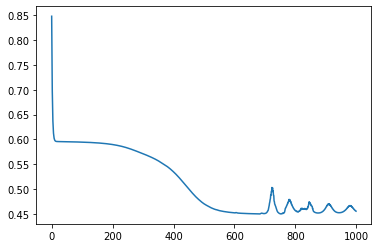

In [15]:
# Ex. 1.4: Lets fit a circle :)

input_features, labels = generate_circle_data(n_samples=900)

torch.manual_seed(8)
model = ThreeLayerNN()
epochs = 1000
learning_rate = 0.1
losses = train(model, epochs, input_features, labels, loss_function, learning_rate)

plt.plot(losses)
plt.show()
plot_boundary_and_input_features(model.layer0_1, input_features, labels, "Layer0_1", 'red')
plot_boundary_and_input_features(model.layer0_0, input_features, labels, "Layer0_0", 'green')
# uncommment for three layer
plot_boundary_and_input_features(model.layer0_2, input_features, labels, "Layer0_2", 'blue')

plot_neural_network_response(model)

plt.show()
